<a href="https://colab.research.google.com/github/Varghese-Kuruvilla/Road-Segmentation/blob/master/ShelfNet_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Startup code on google colab
# !unzip /content/drive/My\ Drive/Rbccps/Semantic-segmentation/ShelfNet_v1/ShelfNet18_realtime.zip -d /content/
# !unzip /content/drive/My\ Drive/Rbccps/Semantic-segmentation/ShelfNet_v1/homography_computation.zip -d /content/
#!pip install ninja

In [ ]:
#Command to zip and save to google drive
# !zip -r ShelfNet18_realtime.zip ShelfNet18_realtime/
# !zip -r homography_computation.zip homography_computation
# mv ShelfNet18_realtime.zip /content/drive/My\ Drive/Rbccps/Semantic-segmentation/ShelfNet_v1
# mv homography_computation.zip /content/drive/My\ Drive/Rbccps/Semantic-segmentation/ShelfNet_v1/

In [ ]:
%%writefile /content/ShelfNet18_realtime/evaluate.py
#!/usr/bin/python
# -*- encoding: utf-8 -*-
from logger import setup_logger
from cityscapes import CityScapes

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.distributed as dist

import os
import os.path as osp
import logging
import time
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from tqdm import tqdm
import math
from PIL import Image
from shelfnet import ShelfNet


class MscEval(object):
    def __init__(self,
            model,
            dataloader,
            scales = [ 1.0],
            n_classes = 19,#19
            lb_ignore = 255,
            cropsize = 1024,
            flip = False,
            *args, **kwargs):
        self.scales = scales
        self.n_classes = n_classes
        self.lb_ignore = lb_ignore
        self.flip = flip
        self.cropsize = cropsize
        ## dataloader
        self.dl = dataloader
        self.net = model


    def pad_tensor(self, inten, size):
        N, C, H, W = inten.size()
        outten = torch.zeros(N, C, size[0], size[1]).cuda()
        outten.requires_grad = False
        margin_h, margin_w = size[0]-H, size[1]-W
        hst, hed = margin_h//2, margin_h//2+H
        wst, wed = margin_w//2, margin_w//2+W
        outten[:, :, hst:hed, wst:wed] = inten
        return outten, [hst, hed, wst, wed]


    def eval_chip(self, crop):
        with torch.no_grad():
            out = self.net(crop)[0]
            prob = F.softmax(out, 1)
            if self.flip:
                crop = torch.flip(crop, dims=(3,))
                out = self.net(crop)[0]
                out = torch.flip(out, dims=(3,))
                prob += F.softmax(out, 1)
            #prob = torch.exp(prob)
        return prob


    def crop_eval(self, im):
        cropsize = self.cropsize
        stride_rate = 1.0
        N, C, H, W = im.size()
        long_size, short_size = (H,W) if H>W else (W,H)
        if long_size < cropsize:
            im, indices = self.pad_tensor(im, (cropsize, cropsize))
            prob = self.eval_chip(im)
            prob = prob[:, :, indices[0]:indices[1], indices[2]:indices[3]]
        else:
            stride = math.ceil(cropsize*stride_rate)
            if short_size < cropsize:
                if H < W:
                    im, indices = self.pad_tensor(im, (cropsize, W))
                else:
                    im, indices = self.pad_tensor(im, (H, cropsize))
            N, C, H, W = im.size()
            n_x = math.ceil((W-cropsize)/stride)+1
            n_y = math.ceil((H-cropsize)/stride)+1
            prob = torch.zeros(N, self.n_classes, H, W).cuda()
            prob.requires_grad = False
            for iy in range(n_y):
                for ix in range(n_x):
                    hed, wed = min(H, stride*iy+cropsize), min(W, stride*ix+cropsize)
                    hst, wst = hed-cropsize, wed-cropsize
                    chip = im[:, :, hst:hed, wst:wed]
                    prob_chip = self.eval_chip(chip)
                    prob[:, :, hst:hed, wst:wed] += prob_chip
            if short_size < cropsize:
                prob = prob[:, :, indices[0]:indices[1], indices[2]:indices[3]]
        return prob


    def scale_crop_eval(self, im, scale):
        N, C, H, W = im.size()
        new_hw = [int(H*scale), int(W*scale)]
        im = F.interpolate(im, new_hw, mode='bilinear', align_corners=True)
        prob = self.crop_eval(im)
        prob = F.interpolate(prob, (H, W), mode='bilinear', align_corners=True)
        return prob


    def compute_hist(self, pred, lb):
        n_classes = self.n_classes
        ignore_idx = self.lb_ignore
        keep = np.logical_not(lb==ignore_idx)
        merge = pred[keep] * n_classes + lb[keep]
        hist = np.bincount(merge, minlength=n_classes**2)
        hist = hist.reshape((n_classes, n_classes))
        return hist


    def evaluate(self):
        ## evaluate
        n_classes = self.n_classes
        hist = np.zeros((n_classes, n_classes), dtype=np.float32)
        dloader = tqdm(self.dl)
        if dist.is_initialized() and not dist.get_rank()==0:
            dloader = self.dl
        for i, (imgs, label) in enumerate(dloader):
            # print("lkdhsdx",label.shape)
            print("imgs.size()",imgs.size())
            print("imgs.type()",imgs.type())
            N,_, H, W = label.shape
            probs = torch.zeros((N, self.n_classes, H, W))
            probs.requires_grad = False
            imgs = imgs.cuda()
            for sc in self.scales:
                prob = self.scale_crop_eval(imgs, sc)
                probs += prob.detach().cpu()
            probs = probs.data.numpy()
            preds = np.argmax(probs, axis=1)

            #Changed 
            # preds_test = preds.squeeze()
            # preds_test[preds_test == 7] = 255
            # preds_test = preds_test.astype(np.uint8)
            # cv2.imwrite("inf_"+str(i) + ".png",preds_test)           
            
            #Indicate road region in white
            # print(preds,"dfjdhgduijfduifd",label.data.numpy().squeeze(1))
            # palette = np.random.randint(0, 256, (256, 3), dtype=np.uint8)
            # pred = palette[preds[1]]
            # cv2.imwrite("./res/{}.png".format(i),pred)
            # print("sllkjdisydhkasnalk",preds[1])
            
#             out_img = Image.fromarray(preds[1])
#             citypall=[
# 128,64,128,244,35,232,70,70,70,102,102,156,190,153,153,153,153,153,250,170,30,220,220,0,107,142,35,152,251,152,70,130,180,220,20,60,255,0,0,0,0,142,0,0,70,0,60,100,0,80,100,0,0,230,119,11,32,128,192,0,0,64,128,128,64,128,0,192,128,128,192,128,64,64,0,192,64,0,64,192,0,192,192,0,64,64,128,192,64,128,64,192,128,192,192,128,0,0,64,128,0,64,0,128,64,128,128,64,0,0,192,128,0,192,0,128,192,128,128,192,64,0,64,192,0,64,64,128,64,192,128,64,64,0,192,192,0,192,64,128,192,192,128,192,0,64,64,128,64,64,0,192,64,128,192,64,0,64,192,128,64,192,0,192,192,128,192,192,64,64,64,192,64,64,64,192,64,192,192,64,64,64,192,192,64,192,64,192,192,192,192,192,32,0,0,160,0,0,32,128,0,160,128,0,32,0,128,160,0,128,32,128,128,160,128,128,96,0,0,224,0,0,96,128,0,224,128,0,96,0,128,224,0,128,96,128,128,224,128,128,32,64,0,160,64,0,32,192,0,160,192,0,32,64,128,160,64,128,32,192,128,160,192,128,96,64,0,224,64,0,96,192,0,224,192,0,96,64,128,224,64,128,96,192,128,224,192,128,32,0,64,160,0,64,32,128,64,160,128,64,32,0,192,160,0,192,32,128,192,160,128,192,96,0,64,224,0,64,96,128,64,224,128,64,96,0,192,224,0,192,96,128,192,224,128,192,32,64,64,160,64,64,32,192,64,160,192,64,32,64,192,160,64,192,32,192,192,160,192,192,96,64,64,224,64,64,96,192,64,224,192,64,96,64,192,224,64,192,96,192,192,224,192,192,0,32,0,128,32,0,0,160,0,128,160,0,0,32,128,128,32,128,0,160,128,128,160,128,64,32,0,192,32,0,64,160,0,192,160,0,64,32,128,192,32,128,64,160,128,192,160,128,0,96,0,128,96,0,0,224,0,128,224,0,0,96,128,128,96,128,0,224,128,128,224,128,64,96,0,192,96,0,64,224,0,192,224,0,64,96,128,192,96,128,64,224,128,192,224,128,0,32,64,128,32,64,0,160,64,128,160,64,0,32,192,128,32,192,0,160,192,128,160,192,64,32,64,192,32,64,64,160,64,192,160,64,64,32,192,192,32,192,64,160,192,192,160,192,0,96,64,128,96,64,0,224,64,128,224,64,0,96,192,128,96,192,0,224,192,128,224,192,64,96,64,192,96,64,64,224,64,192,224,64,64,96,192,192,96,192,64,224,192,192,224,192,32,32,0,160,32,0,32,160,0,160,160,0,32,32,128,160,32,128,32,160,128,160,160,128,96,32,0,224,32,0,96,160,0,224,160,0,96,32,128,224,32,128,96,160,128,224,160,128,32,96,0,160,96,0,32,224,0,160,224,0,32,96,128,160,96,128,32,224,128,160,224,128,96,96,0,224,96,0,96,224,0,224,224,0,96,96,128,224,96,128,96,224,128,224,224,128,32,32,64,160,32,64,32,160,64,160,160,64,32,32,192,160,32,192,32,160,192,160,160,192,96,32,64,224,32,64,96,160,64,224,160,64,96,32,192,224,32,192,96,160,192,224,160,192,32,96,64,160,96,64,32,224,64,160,224,64,32,96,192,160,96,192,32,224,192,160,224,192,96,96,64,224,96,64,96,224,64,224,224,64,96,96,192,224,96,192,96,224,192,0,0,0]
#             outimg=out_img.putpalette(citypall)
#             print("kshdshd",outimg)
            

            # hist_once = self.compute_hist(preds, label.data.numpy().squeeze(1))
            # print(hist_once.shape)
            # hist = hist + hist_once
        # print("jhusgds",hist)
        # print("kdkdfkdmf",np.sum(hist, axis=0),"dfdfkdfjdkfd",np.sum(hist, axis=1),"dnfdjfdnfdjf",np.diag(hist))
        # print("diagggagg",np.diag(hist))
        # print("axisssisis",(np.sum(hist, axis=0)+np.sum(hist, axis=1)-np.diag(hist)))
        #Changed
        # palette = np.random.randint(0, 256, (256, 3), dtype=np.uint8)
        # try:
        #     pred = palette[preds[1]]
        #     pred = palette[preds]
        #     cv2.imwrite("./result.png",pred)
        # except Exception as e:
        #     print(e)

        # IOUs = np.diag(hist) / (np.sum(hist, axis=0)+np.sum(hist, axis=1)-np.diag(hist))
        # print("iouououo",IOUs)
        # mIOU = np.mean(IOUs)
        # return mIOU
        return 0


def evaluate(respth='./res', dspth='./data/cityscapes', checkpoint=None):
    ## logger
    logger = logging.getLogger()

    ## model
    logger.info('\n')
    logger.info('===='*20)
    logger.info('evaluating the model ...\n')
    logger.info('setup and restore model')
    n_classes = 19#19
    net = ShelfNet(n_classes=n_classes)

    if checkpoint is None:
        save_pth = osp.join(respth, 'model_final_iiscidd.pth')
    else:
        save_pth = checkpoint

    net.load_state_dict(torch.load(save_pth))
    net.cuda()
    net.eval()

    ## dataset
    batchsize = 1
    n_workers = 10
    dsval = CityScapes(dspth, mode='test')
    # print("sjdusgdsds",dsval)
    dl = DataLoader(dsval,
                    batch_size = batchsize,
                    shuffle = False,
                    num_workers = n_workers,
                    drop_last = False)
    print("len(dl)",len(dl))

    ## evaluator
    logger.info('compute the mIOU')
    evaluator = MscEval(net, dl, scales=[1.0],flip=False)
    ## eval
    mIOU = evaluator.evaluate()
    logger.info('mIOU is: {:.6f}'.format(mIOU))



if __name__ == "__main__":
    setup_logger('./res')    evaluate()

Overwriting /content/ShelfNet18_realtime/evaluate.py


In [ ]:
# %%writefile auto_park_utils.py
import torch
import torchvision.transforms as transforms
import cv2 
from google.colab.patches import cv2_imshow
from PIL import Image
import numpy as np 
import glob
import sys

sys.path.insert(1, '/content/ShelfNet18_realtime/')
from evaluate import MscEval
from shelfnet import ShelfNet

class auto_park_vision():
    def __init__(self,weights_path):

        self.n_classes = 19
        #Homography matrix
        self.H = np.array([[1.132372123443505,-3.359375305984110, 843.835898580380217],
                [0.604347080571571 ,-0.324814498163494 ,955.938833468783173],
                [0.001378608429514 ,-0.000531862797747, 1.000000000000000]])
        #Point indicating potential parking spot
        self.midpoint = []
        self.point_3d = None #3D point corresponding to self.midpoint
        self.eval_define() #Define Object of class MscEval
        #self.evaluator is an object of the class MscEval

    def forward_pass(self,frame=None,img_path=None):

        if(img_path != None):
            img = Image.open(img_path)
        else:
            img = frame 
        orig_img = np.array(img)
        # orig_img = cv2.imread(img_path)
        # cv2_imshow(img)
        #Preprocess Image
        to_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])
        img = to_tensor(img)
        

        _, H, W = img.shape
        # print("H,W:",H,W)
        #Change image size to the form NCHW from CHW
        img = img.unsqueeze(0)

        probs = torch.zeros((1, self.n_classes, H, W))
        probs.requires_grad = False
        img = img.cuda()        

        # for sc in self.scales:
        prob = self.evaluator.scale_crop_eval(img, scale=1.0) #prob.type torch.cuda.FloatTensor
        prob = prob.detach().cpu()
        prob = prob.data.numpy()
        preds = np.argmax(prob, axis=1) #preds.dtype int64
        # palette = np.random.randint(0, 256, (256, 3), dtype=np.uint8)
        # pred = palette[preds.squeeze()]

        #Changed 
        preds = preds.squeeze().astype(np.uint8)
        preds[preds == 0] = 255
        preds = preds.astype(np.uint8)
        return preds
        # overlay = np.copy(preds)
        # overlay = cv2.cvtColor(overlay,cv2.COLOR_GRAY2RGB)
        # cv2_imshow(preds)
        #Overlay preds over the original image
        # alpha = 0.5
        # cv2.addWeighted(overlay, alpha, orig_img, 1 - alpha,0, orig_img)
        # cv2_imshow(orig_img)
        # orig_img = self.parking_spot_detection(preds,orig_img)
        # return orig_img

    def image_to_world(self,point_2d):
        '''
        Function to find out world coordinates
        given an image point
        '''
        #TODO: Check homography matrix
        # print("point.shape",point.shape)
        #Conversion to homogenous coordinates
        point_2d = np.append(point_2d,1).reshape(-1,1)

        H_inv = np.linalg.inv(self.H)
        self.point_3d = np.dot(H_inv,point_2d)
        self.point_3d = self.point_3d / self.point_3d[2,0]
        return self.point_3d




    def eval_define(self):

        n_classes = self.n_classes
        net = ShelfNet(n_classes=n_classes)

        net.load_state_dict(torch.load(weights_path))
        net.cuda()
        net.eval()
        self.evaluator = MscEval(net, dataloader=None, scales=[1.0],flip=False)


# if __name__ == '__main__':
#     weights_path = '/content/ShelfNet18_realtime/res/model_final_final_iisc_idd_16kweights.pth'
#     auto_park_obj = auto_park_vision(weights_path)

#     save_num = 0
#     count = 0
#     servoing_flag = 0

#     # cap = cv2.VideoCapture('/content/ShelfNet18_realtime/auto_park_module/video/ece_loop.mp4')
#     # while(cap.isOpened()):
#         # ret, frame = cap.read()
#         # if(ret == True):
#         #Convert opencv Image to PIL Image
#     for img_path in glob.glob('/content/homography_computation/data/*.png'):
#         if(servoing_flag == 0):
#             frame = cv2.imread(img_path)
#             # frame = cv2.imread('/content/homography_computation/data/rbc_data_00061.png')
#             frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#             frame_pil = Image.fromarray(frame)
#             seg_img = auto_park_obj.forward_pass(frame_pil,img_path=None)
#             cv2.imwrite(img_path.split('.png')[0] + '_overlay.png',seg_img)


In [ ]:
import glob
import numpy as np
import cv2 
import os
from google.colab.patches import cv2_imshow
import time
from statistics import mean
import pickle
#Computed Homography
H = np.array([[23.051566426191190, 38.859138964854033, 626.971467292441275],
              [5.111361028987754, -1.474310992555276, 7144.855081929711559],
              [0.036814327356280, -0.001812769201662, 1.0]])

def world_2d(points_ls):
    '''
    Convert a list of 3d points to corresponding image points using homography
    '''
    points_2d_ls = []
    for point in points_ls:
        point_3d = np.asarray(point)
        point_3d = point_3d.reshape(3,1)
        # print("point_3d",point_3d)
        point_2d = np.dot(H,point_3d)
        point_2d = point_2d // point_2d[2,0]
        points_2d_ls.append(point_2d)
        # print("point_2d",point_2d)
    return points_2d_ls

def project_points(img,points_2d_ls):
    '''
    Draw a bounding rectangle on the image using the computed homography
    '''
    # cv2_imshow(img)
    # for point_2d in points_2d_ls:
    #     cv2.circle(img,(point_2d[0],point_2d[1]), 5, (0,0,255), -1)
        
    #For visualization
    N = len(points_2d_ls)
    for i in range(0,N):
        cv2.line(img,(points_2d_ls[i%N][0],points_2d_ls[i%N][1]),\
                 (points_2d_ls[(i+1)%N][0],points_2d_ls[(i+1)%N][1]),\
                 (0,0,255),4)
    #Image with points drawn on it
    cv2_imshow(img)

def pot_parking_spot(orig_img,inf_img,points_2d_ls):
    '''
    Function to detect potential parking spot
    '''
    #TODO: Optimize the code
    xcoords_ls = []
    ycoords_ls = []
    for point in points_2d_ls:
        xcoords_ls.append(point[0][0])
        ycoords_ls.append(point[1][0])
    
    #Line equations of the top and bottom line
    coeff_top = np.polyfit(xcoords_ls[0:2],ycoords_ls[0:2],1)
    line_top = np.poly1d(coeff_top)

    coeff_bottom = np.polyfit(xcoords_ls[2:4],ycoords_ls[2:4],1)
    line_bottom = np.poly1d(coeff_bottom)
    # print("line_bottom",line_bottom)
    # print("line_top",line_top)
    flag_top = 0
    flag_bottom = 0
    #Points for potential parking spot
    pt_tl = []
    pt_tr = []
    pt_bl = []
    pt_br = []
    for x in range(0,inf_img.shape[1]):
        if(inf_img[int(line_top(x)),x] == 255 and flag_top == 0):
            pt_tl = [int(line_top(x)),x]
            pt_tr = [int(line_top(x+200)),int(x+200)]
            # cv2.circle(orig_img,(pt_tl[1],pt_tl[0]), 5, (0,0,255), -1)
            # cv2.circle(orig_img,(pt_tr[1],pt_tr[0]), 5, (0,0,255), -1)
            # cv2_imshow(orig_img)
            flag_top = 1

        if(inf_img[int(line_bottom(x)),x] == 255 and flag_bottom == 0):
            pt_bl = [int(line_bottom(x)),x]
            pt_br = [int(line_bottom(x+200)),int(x+200)]
            # cv2.circle(orig_img,(pt_bl[1],pt_bl[0]), 5, (0,0,255), -1)
            # cv2.circle(orig_img,(pt_br[1],pt_br[0]), 5, (0,0,255), -1)
            # cv2_imshow(orig_img)
            flag_bottom = 1
        
        if(flag_top == 1 and flag_bottom ==1):
            # cv2_imshow(orig_img)
            break

    if(flag_top == 1 and flag_bottom == 1):
        cv2.line(orig_img,(pt_tl[1],pt_tl[0]),(pt_tr[1],pt_tr[0]),(0,0,255),2)
        cv2.line(orig_img,(pt_tr[1],pt_tr[0]),(pt_br[1],pt_br[0]),(0,0,255),2)
        cv2.line(orig_img,(pt_br[1],pt_br[0]),(pt_bl[1],pt_bl[0]),(0,0,255),2)
        cv2.line(orig_img,(pt_bl[1],pt_bl[0]),(pt_tl[1],pt_tl[0]),(0,0,255),2)
    
    pt_ls = [pt_bl,pt_br,pt_tr,pt_tl]
    return orig_img,pt_ls
    
    
    


# if __name__ == '__main__':
#     # img = cv2.imread('/content/homography_computation/data/rbc_data_00061.png')
#     weights_path = '/content/ShelfNet18_realtime/res/model_final_final_iisc_idd_16kweights.pth'
#     auto_park_obj = auto_park_vision(weights_path)
#     points_ls = [[620,200,1],[620,-200,1],[1120,-200,1],[1120,200,1]]
#     points_2d_ls = world_2d(points_ls) #[967,427],[295,438],[438,309],[817,300]
#     # print("points_2d_ls",points_2d_ls)
#     count = 0 #For debug
#     avg_time_ls = []
#     # cap = cv2.VideoCapture('/content/homography_computation/data/logi2.webm')
#     # frame_width = int(cap.get(3))
#     # frame_height = int(cap.get(4))
#     # size = (frame_width,frame_height)

#     #For debug
#     count = 0
#     ret = True
#     # result = cv2.VideoWriter('seg_output.avi',cv2.VideoWriter_fourcc(*'MJPG'),\
#                             #  10,size,0)
#     global_ls = []
#     # while(ret == True):
#     for img_path in glob.glob('/content/_out_subset/*.png'):
#         # ret, frame = cap.read()
#         # if(ret == False):
#         #     print("len(global_ls)",len(global_ls))
#         #     print(global_ls[100])
#         #     with open("pt_ls.data","wb") as filehandle:
#         #         pickle.dump(global_ls,filehandle)
#         #     break

#         frame = cv2.imread(img_path)
#         frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         frame_pil = Image.fromarray(frame)

#         seg_img = auto_park_obj.forward_pass(frame_pil,img_path=None)
        
#         #Overlay segmented image on the original frame
#         overlay = np.copy(seg_img)
#         overlay = cv2.cvtColor(overlay,cv2.COLOR_GRAY2RGB)
#         alpha = 0.5
#         cv2.addWeighted(overlay, alpha, frame, 1 - alpha,0, frame)
#         cv2_imshow(frame)
#         # res_img,pt_ls = pot_parking_spot(frame,seg_img,points_2d_ls)
#         # global_ls.append(pt_ls)
#         # result.write(seg_img)
#         # cv2_imshow(res_img)
#         # break
#         # img_name = os.path.basename(inf_path)
#         # cv2.imwrite("/content/homography_computation/parking_spot_results/"+\
#                     # img_name.split('_inf.png')[0] + '_spot.png',res_img)
#         if(count % 500 == 0):
#             print("Processed", 500*(count/500),"frames")
#         count += 1
#         # print("count",count)
        
#     # project_points(img,points_2d_ls)
#     # result.release()

#     #Read the list back
#     # read_ls = []
#     # with open("pt_ls.data","rb") as filehandle:
#     #     read_ls = pickle.load(filehandle)
#     #     print("len(read_ls)",len(read_ls))
#     # print(read_ls[100])
#     # cap.release()


In [ ]:
!unzip _out_subset.zip -d /content/

Archive:  _out_subset.zip
   creating: /content/_out_subset/
  inflating: /content/_out_subset/00032770.png  
  inflating: /content/_out_subset/00022191.png  
  inflating: /content/_out_subset/00031626.png  
  inflating: /content/_out_subset/00034085.png  
  inflating: /content/_out_subset/00028528.png  
  inflating: /content/_out_subset/00021455.png  
  inflating: /content/_out_subset/00028063.png  
  inflating: /content/_out_subset/00033048.png  
  inflating: /content/_out_subset/00026069.png  
  inflating: /content/_out_subset/00026595.png  
  inflating: /content/_out_subset/00029142.png  
  inflating: /content/_out_subset/00026086.png  
  inflating: /content/_out_subset/00027258.png  
  inflating: /content/_out_subset/00020540.png  
  inflating: /content/_out_subset/00028569.png  
  inflating: /content/_out_subset/00027105.png  
  inflating: /content/_out_subset/00026103.png  
  inflating: /content/_out_subset/00027133.png  
  inflating: /content/_out_subset/00025363.png  
  inflat

In [ ]:
#TODO:
#sys.path.insert(1, '/content/ShelfNet18_realtime/')

['', '/content/ShelfNet18_realtime/', '/content/ShelfNet18_realtime/', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

cam_to_car = np.array([[-6.12323400e-17 ,-6.12323400e-17,  1.00000000e+00,  3.00000000e-01],
                       [-1.00000000e+00 , 3.74939946e-33, -6.12323400e-17,  0.00000000e+00],
                       [ 0.00000000e+00 , 1.00000000e+00,  6.12323400e-17,  1.30000000e+00],
                       [ 0.00000000e+00 , 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

car_to_world = np.array([[ 2.38548938e-06,  1.05023635e-04, -9.99999994e-01,  2.70740145e+02],
                        [ 9.99999994e-01 , 1.08124080e-04 , 2.39684497e-06 , 1.29490238e+02],
                        [-1.08124331e-04 , 9.99999989e-01 , 1.05023376e-04 , 3.94027384e+01],
                        [ 0.00000000e+00 , 0.00000000e+00 , 0.00000000e+00 , 1.00000000e+00]])

world_transform = np.array([[-9.99999994e-01, -2.38548938e-06,  1.05023635e-04,  2.71040009e+02],
                            [ 2.39684497e-06, -9.99999994e-01,  1.08124080e-04,  1.29490097e+02],
                            [ 1.05023376e-04,  1.08124331e-04,  9.99999989e-01,  3.81027069e+01],
                            [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

window_width = 1280
window_height = 720
ext_mat = world_transform @ cam_to_car

intrinsic_mat = np.array([[1.13119617e+03, 0.00000000e+00, 6.40000000e+02],
                        [0.00000000e+00, 1.13119617e+03, 3.60000000e+02],
                        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
def carla_world_2d(world_points):
    '''
    Takes an array of world points and converts them into corresponding image points
    '''
    
    pts_2d_ls = [] #List of 2d points
    for point in world_points:
        world_coord = np.asarray(point).reshape(4,-1)
        print("world_coord.shape",world_coord.shape)
        # world_coord = np.array([[250.0 ,129.0 ,38.0 ,1.0]]).reshape(4,-1)
        cam_coord = np.linalg.inv(ext_mat) @ world_coord
        img_coord = intrinsic_mat @ cam_coord[:3]
        img_coord = np.array([img_coord[0]/img_coord[2],
                            img_coord[1]/img_coord[2],
                            img_coord[2]])

        if(img_coord[2] > 0):
            x_2d = window_width - img_coord[0]
            y_2d = window_height - img_coord[1]
            pts_2d_ls.append([x_2d,y_2d,1.0])
        
    return pts_2d_ls
    # print("x_2d",x_2d)
    # print("y_2d",y_2d)
    # cv2.circle(frame, (x_2d,y_2d), radius=5 , color=(255,0,0), thickness=-1)
    # cv2_imshow(frame)
    # print("cam_coord",cam_coord)
    # print("img_coord",img_coord)





# if __name__ == '__main__':
    # chk_cam_params()

world_coord.shape (4, 1)
world_coord.shape (4, 1)
world_coord.shape (4, 1)
world_coord.shape (4, 1)
points_2d_ls [[array([645.16570838]), array([434.77245428]), 1.0], [array([72.11893982]), array([434.71040333]), 1.0], [array([642.56731441]), array([397.20142459]), 1.0], [array([357.91828289]), array([397.17062474]), 1.0]]


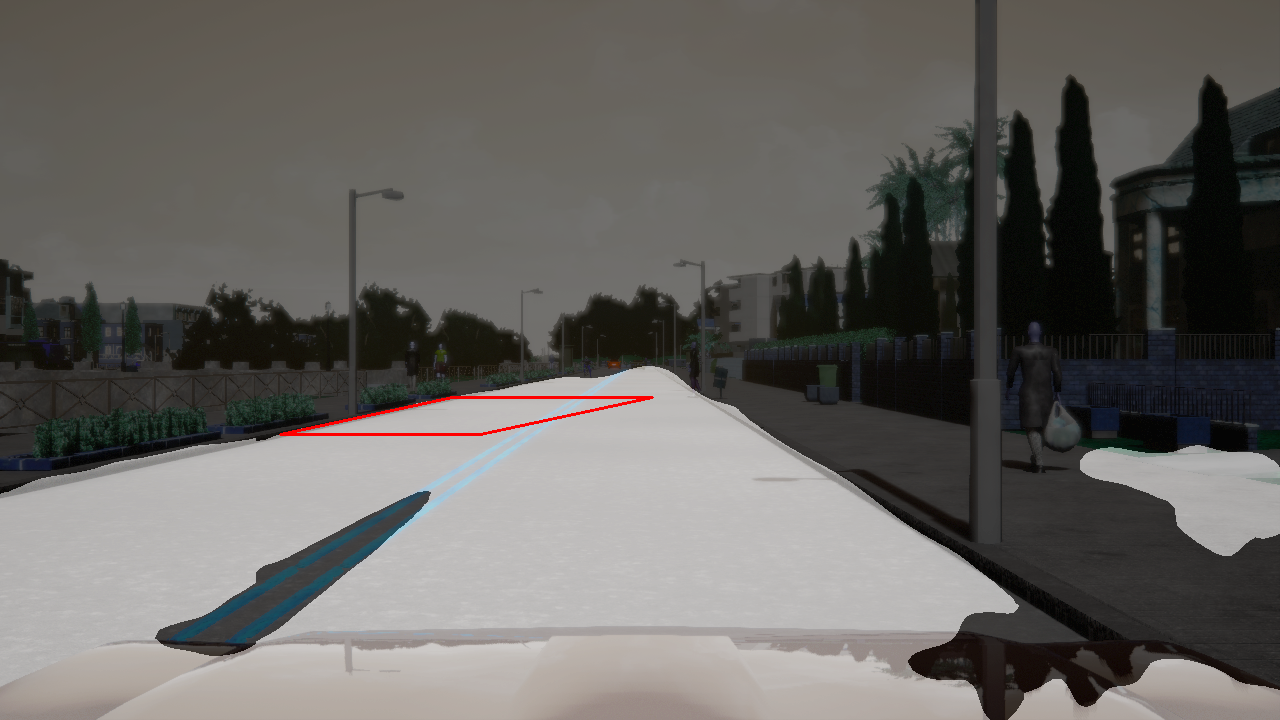

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[415.5 466. ]


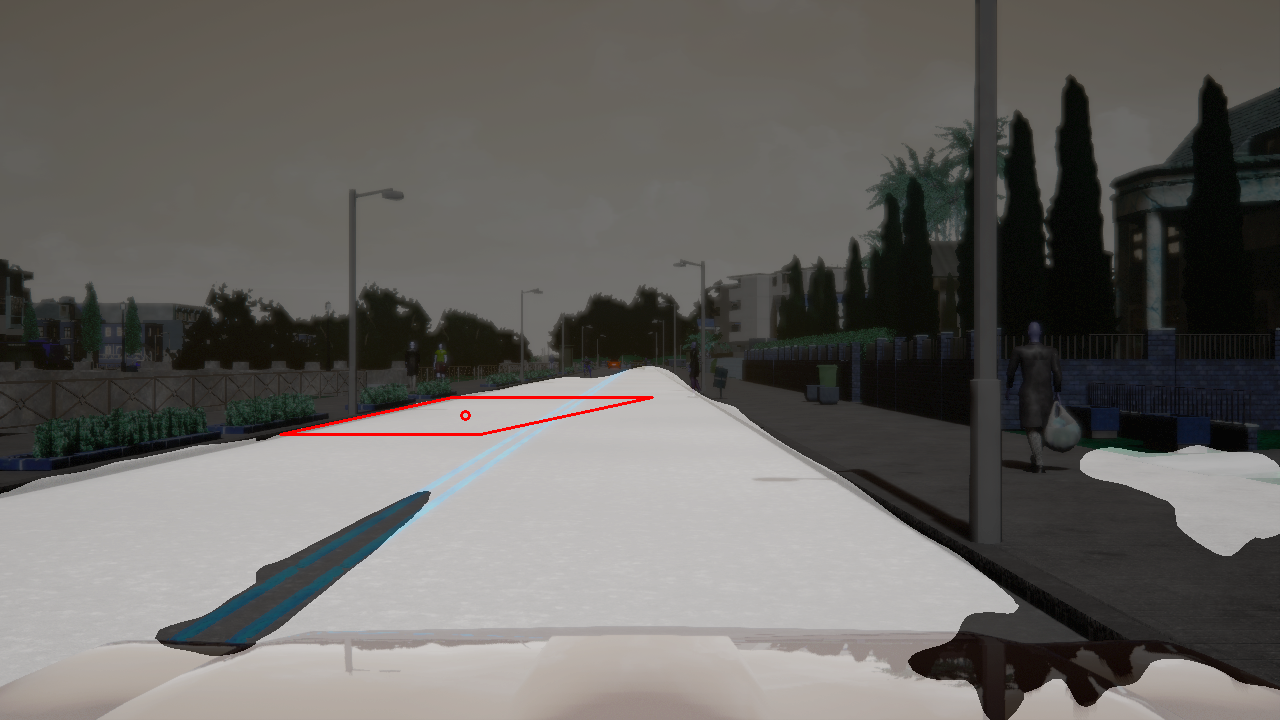

In [ ]:
#For Carla simulation
import glob
import numpy as np
import cv2 
import os
from google.colab.patches import cv2_imshow
import time
from statistics import mean
import pickle


def ret_line_eq(pt1,pt2):
    '''
    Returns m1,c1 given 2 points
    '''
    points = [pt1,pt2]
    x_coords, y_coords = zip(*points)
    A = np.vstack([x_coords,np.ones(len(x_coords))]).T
    m1, c1 = np.linalg.lstsq(A, y_coords)[0] #TODO: Improve this, it computes the least square solution
    return m1,c1

def find_midpoint(pt_ls):
    '''
    Find the midpoint(image coordinates) given 4 corners of the contour
    '''
    m1,c1 = ret_line_eq(pt_ls[0],pt_ls[2])
    m2,c2 = ret_line_eq(pt_ls[1],pt_ls[3])

    #Solve the 2 eqns to obtain the midpoint
    A = np.array([[-m1,1],
                 [-m2,1]],dtype=np.float64)
    B = np.array([c1,c2])
    midpoint = np.linalg.inv(A).dot(B)
    return midpoint
    #Inverse homography matrix
    # inv_h = np.linalg.inv(H)
    # #Conversion from Numpy coordinates to OpenCV coordinates
    # #TODO: Optimize this computation
    # midpoint_homography = np.copy(midpoint).reshape(2,1)
    # midpoint_homography[0,0] = midpoint[1]
    # midpoint_homography[1,0] = midpoint[0]
    # midpoint_homography = np.append(midpoint_homography,1).reshape(-1,1)
    # # midpoint_homography.append(midpoint[0])
    # # midpoint_homography.append(1)
    # world_midpoint = np.dot(inv_h,midpoint_homography)
    # world_midpoint = world_midpoint / world_midpoint[2,0]
    # return world_midpoint 








if __name__ == '__main__':
    # img = cv2.imread('/content/homography_computation/data/rbc_data_00061.png')
    # weights_path = '/content/ShelfNet18_realtime/res/model_final_final_iisc_idd_16kweights.pth'
    auto_park_obj = auto_park_vision(weights_path)
    points_ls = [[251.0,129.4,38.1,1.0],[251.0,139.4,38.1,1.0],
                 [231.0,129.4,38.1,1.0],[231.0,139.4,38.1,1.0]]
    points_2d_ls = carla_world_2d(points_ls) #[967,427],[295,438],[438,309],[817,300]
    print("points_2d_ls",points_2d_ls)
   
    
    #For debug
    # count = 0
    # ret = True

    for img_path in glob.glob('/content/carla_images/*.png'):
 
        frame = cv2.imread(img_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_pil = Image.fromarray(frame)

        seg_img = auto_park_obj.forward_pass(frame_pil,img_path=None)

        #Overlay segmented image on the original frame
        overlay = np.copy(seg_img)
        overlay = cv2.cvtColor(overlay,cv2.COLOR_GRAY2RGB)
        alpha = 0.5
        cv2.addWeighted(overlay, alpha, frame, 1 - alpha,0, frame)
        # cv2_imshow(frame)
        res_img,pt_ls = pot_parking_spot(frame,seg_img,points_2d_ls)
        cv2_imshow(res_img)
        midpoint = find_midpoint(pt_ls)
        print(midpoint)
        cv2.circle(res_img,(int(midpoint[1]),int(midpoint[0])),radius=4,color=(0,0,255),thickness = 2)
        cv2_imshow(res_img)

In [ ]:
print("Prevent timeout")

Prevent timeout
